In [21]:
import tensorflow as tf
from tensorflow import keras

# double check your tf version
print(tf.__version__)

# get sampling data set
fashion_mnist = keras.datasets.mnist
(trainx, trainy), (testx, testy) = fashion_mnist.load_data()

print("GPU Available: ", tf.test.is_gpu_available())

2.0.0-alpha0
GPU Available:  True


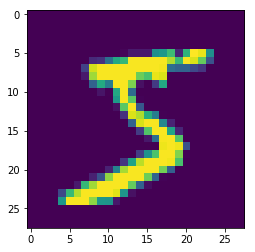

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [22]:
import matplotlib.pyplot as plt
imgplot = plt.imshow(trainx[0])
plt.show()
trainx = trainx / 255.0
testx  = testx / 255.0

print(trainx.shape)
print(trainy.shape)
print(testx.shape)
print(testy.shape)

In [23]:
# reshape your data dimension into 3D (28,28,1)
trainx= trainx.reshape(trainx.shape[0], 28, 28, 1).astype('float32')
testx = testx.reshape(testx.shape[0], 28, 28, 1).astype('float32')

print(trainx.shape)
print(testx.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [24]:
# suggestion from Tutorial, shuffle dataset
TRAIN_BUF = 60000
BATCH_SIZE = 100
TEST_BUF = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(trainx).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(testx).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [25]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.imgur.com/j8MEca6.png")

In [26]:
# dimension : 784 >> 256 >> 2 >> 256 >> 784
oriDim = 784
latentDim = 2
internalDim = 256

In [27]:
# we have a sample of Conv2D CAE
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self.inference_net = tf.keras.Sequential(
          [
              tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
              tf.keras.layers.Conv2D(
                  filters=32, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Conv2D(
                  filters=64, kernel_size=3, strides=(2, 2), activation='relu'),
              tf.keras.layers.Flatten(),
              # No activation
              tf.keras.layers.Dense(latent_dim + latent_dim),
          ]
        )
        
        self.generative_net = tf.keras.Sequential(
            [
              tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
              tf.keras.layers.Dense(units=7*7*32, activation=tf.nn.relu),
              tf.keras.layers.Reshape(target_shape=(7, 7, 32)),
              tf.keras.layers.Conv2DTranspose(
                  filters=64,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              tf.keras.layers.Conv2DTranspose(
                  filters=32,
                  kernel_size=3,
                  strides=(2, 2),
                  padding="SAME",
                  activation='relu'),
              # No activation
              tf.keras.layers.Conv2DTranspose(
                  filters=1, kernel_size=3, strides=(1, 1), padding="SAME"),
            ]
        )
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(100, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean

    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
        return logits

In [28]:

optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    value = tf.reduce_sum(-.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi), axis=raxis) 
    return value

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)

    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    return tape.gradient(loss, model.trainable_variables), loss

def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

In [29]:
epochs = 50
latent_dim = 50
num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim)

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')

    # tight_layout minimizes the overlap between 2 sub-plots
    # plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

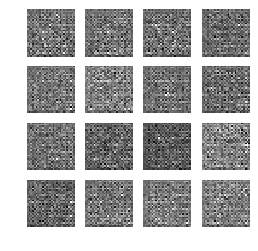

Epoch: 1, Test set ELBO: -190.07235717773438, time elapse for current epoch 26.68625044822693
Epoch: 2, Test set ELBO: -150.79193115234375, time elapse for current epoch 24.36939573287964
Epoch: 3, Test set ELBO: -133.6259002685547, time elapse for current epoch 24.816534280776978
Epoch: 4, Test set ELBO: -125.84974670410156, time elapse for current epoch 23.988186836242676
Epoch: 5, Test set ELBO: -121.07827758789062, time elapse for current epoch 24.54601764678955
Epoch: 6, Test set ELBO: -117.76216888427734, time elapse for current epoch 23.812330722808838
Epoch: 7, Test set ELBO: -115.56123352050781, time elapse for current epoch 24.23996877670288
Epoch: 8, Test set ELBO: -113.71700286865234, time elapse for current epoch 24.56765913963318
Epoch: 9, Test set ELBO: -112.26549530029297, time elapse for current epoch 23.610517263412476
Epoch: 10, Test set ELBO: -111.02761840820312, time elapse for current epoch 23.637836456298828
Epoch: 11, Test set ELBO: -110.18065643310547, time ela

In [31]:
generate_and_save_images(model, 0, random_vector_for_generation)

import time
import numpy as np
from IPython import display

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        #isplay.clear_output(wait=False)
        print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch,
                                                    elbo,
                                                    end_time - start_time))
        #enerate_and_save_images(model, epoch, random_vector_for_generation)

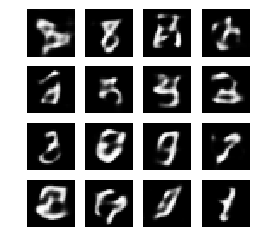

[[[[-0.01289617 -0.04713148 -0.01219821 ...  0.08155244  0.14798802
     0.02998658]
   [ 0.02585726  0.04723215  0.06636256 ...  0.15725012  0.08984984
    -0.03537033]
   [ 0.02360396  0.03670759  0.01168706 ...  0.01846894  0.06203237
    -0.02412214]
   ...
   [-0.012058   -0.02082749  0.03266394 ... -0.01994055  0.07987104
     0.07032313]
   [ 0.05354179 -0.04823022  0.12162715 ...  0.06727296 -0.04703883
     0.0028503 ]
   [-0.01316315  0.03194703  0.07412634 ... -0.04703453  0.06275229
     0.00534841]]

  [[-0.03815949 -0.05214599  0.12145018 ...  0.02024387  0.1146181
     0.13814604]
   [ 0.04349599  0.01986691 -0.00148677 ...  0.13206823  0.14139788
    -0.02067769]
   [-0.06378291 -0.00284375  0.11010823 ...  0.00871168  0.00060054
     0.03884928]
   ...
   [ 0.1340157   0.03059399 -0.00196402 ...  0.02222012 -0.00497755
    -0.0547522 ]
   [ 0.125669    0.05097893 -0.02697129 ... -0.04668712 -0.06790212
     0.00577241]
   [ 0.07990646  0.00887544  0.06894708 ...  0.024

TypeError: Invalid dimensions for image data

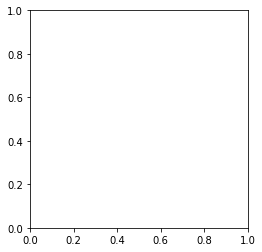

In [50]:
generate_and_save_images(model, 100, random_vector_for_generation)
inference_net_Conv2D_layer1 = model.inference_net.layers[1].get_weights()

# print(inference_net_Conv2D_layer1[0])
print(np.array(inference_net_Conv2D_layer1[0]).shape)

# 解釋一下~ Input通常是28 x 28 x 1 (gray scale) 或 3 (RGB scale)
# 所以第一層convolution layer的形狀考慮unit是32的話
# 通常會是3 x 3 x 32 x 1這種shape
# 不過做完第一層convolution之後他就會輸出一個32個channel的影像
# 所以第二層他的參數個數就會變成3 x 3 x 第二層unit個數 x 第一層unit個數(i.e.,我這邊寫的32)

# https://github.com/jessee-kung/tu-etp-ad1062/blob/master/demo_04.ipynb?fbclid=IwAR3SE1mYaFtKPbQKoE-3TiuOm3lXQZ-WL_kIku_knCou2EyB4UnQ4YEuIJc

plt.imshow(model.inference_net.layers[1].get_weights()[0])
plt.show()

In [1]:
import jovian
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Saving notebook..


<IPython.core.display.Javascript object>

[jovian] Creating a new notebook on https://jvn.io


[jovian] Error: The current API key is invalid or expired.


[jovian] Please enter your API key (from https://jvn.io ):
········
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jvn.io/littlenine/09195d5f88f440d29e23b8849ea83f12


[jovian] Error: Failed to read Anaconda environment using command: "conda env export -n base --no-builds"
